# imports

In [100]:
from noises import *
from phantom import *

import torch
import torch.nn.functional as F

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

# create folders

In [5]:
# make directories
for key in NOISE_FUNCTIONS.keys():
    os.makedirs(f'./{key}', exist_ok=True)

In [7]:
# make directories in the ground truth folder for each resolution
# 64, 128, 256, 512
for res in [64, 128, 256, 512]:
    os.makedirs(f'./ground_truth/{res}', exist_ok=True)


# generate ground truth and sample

In [12]:
# now generate 50 phantoms for each resolution
# save the phantoms to the ground truth folder
for res in [6, 7, 8, 9]:
    for i in range(50):
        # res is 2**res
        # so a 64x64 image has a res of 6
        phantom = generate_phantom(res)
        # save the phantom
        # output is a np array
        np.save(f'./ground_truth/{2**res}/{i}.npy',phantom)

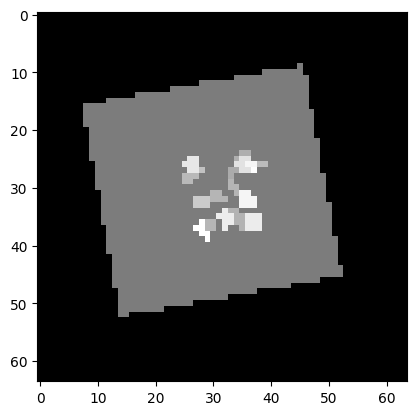

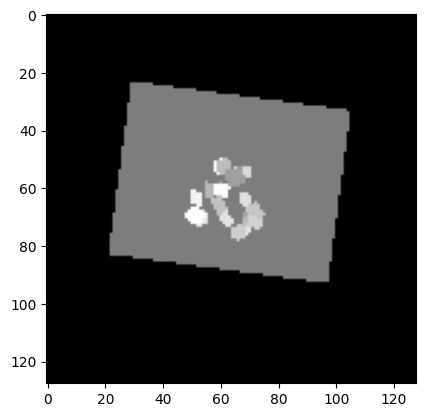

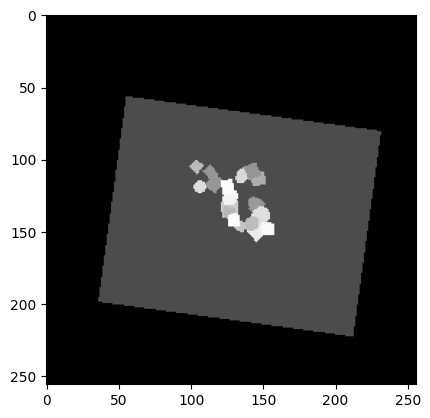

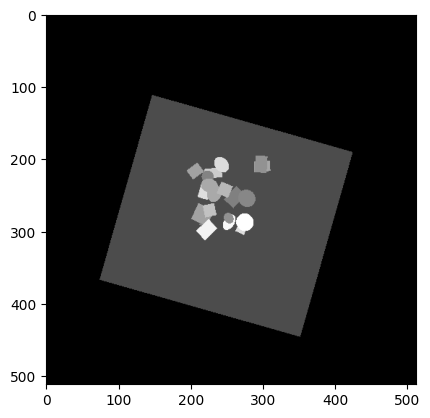

In [19]:
# test plotting one of the phantoms

for res in [6, 7, 8, 9]:
    plt.figure()
    plt.imshow(np.load(f'./ground_truth/{2**res}/0.npy').squeeze(), cmap='gray')

# test noise

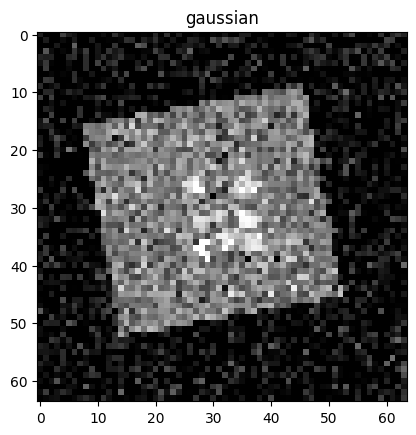

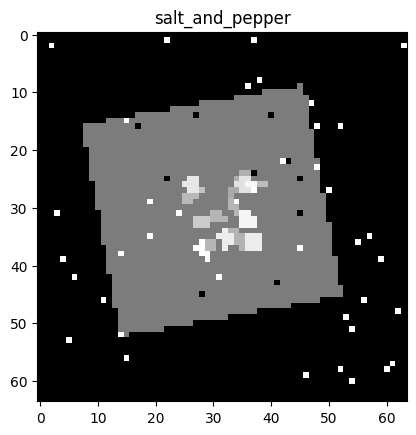

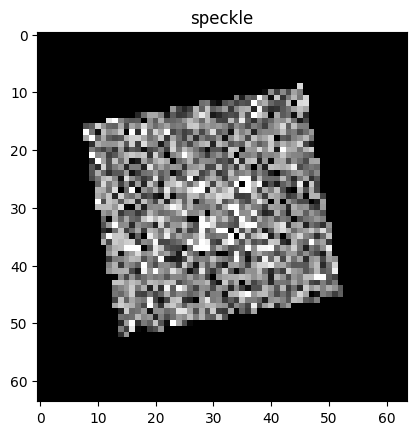

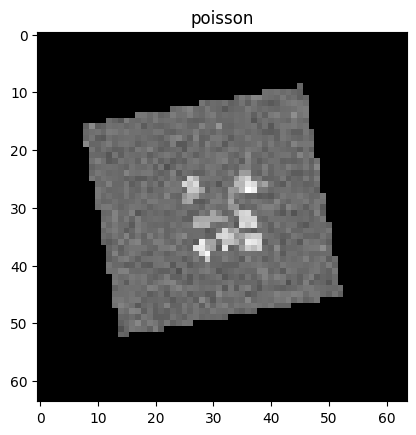

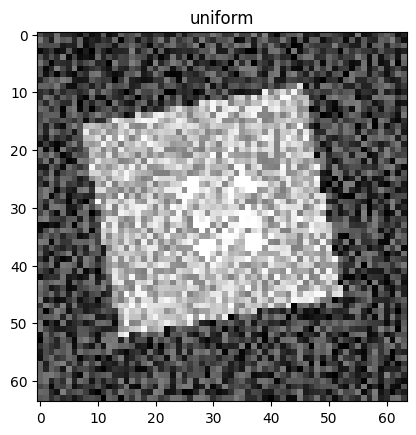

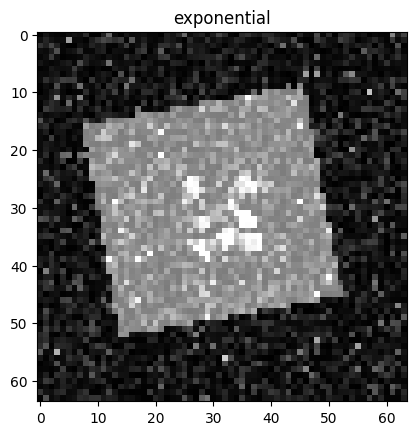

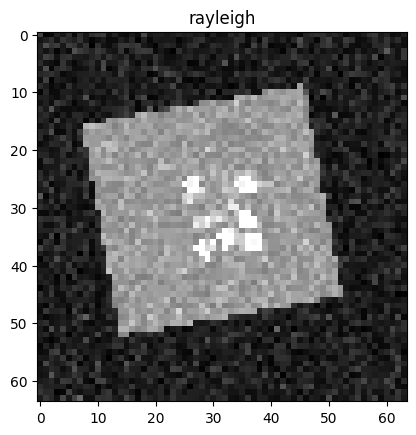

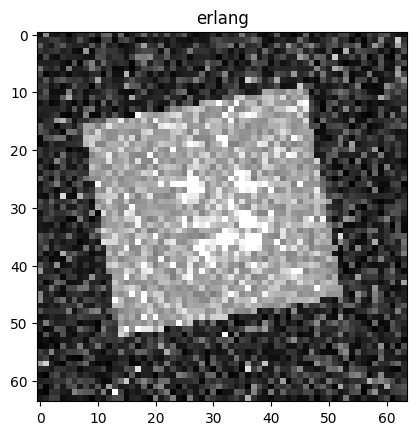

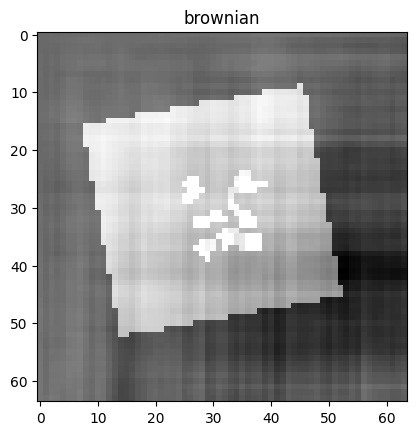

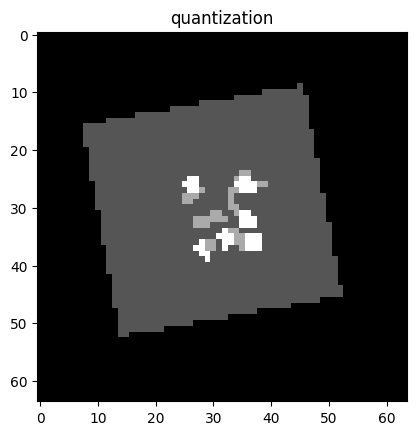

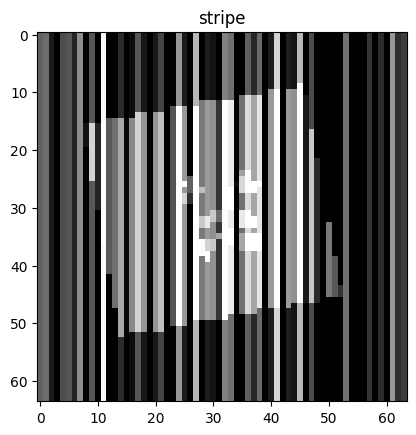

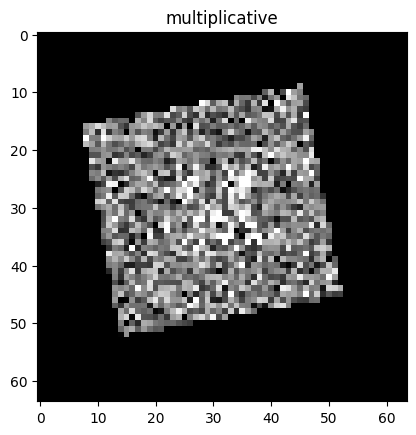

In [2]:
# test applying each noise function to one of the phantoms
# the noise function works like this: add_selected_noise(img, noise_type='gaussian', **kwargs):

img = np.load(f'./ground_truth/64/0.npy').squeeze()
img_torch = phantom_to_torch(img)

for key in NOISE_FUNCTIONS.keys():
    plt.figure()
    noise_img = add_selected_noise(img_torch, noise_type=key)
    # include label of the noise type
    plt.title(key)
    plt.imshow(noise_img.squeeze(), cmap='gray', )

# note all noise is equal

In [126]:

NOISE_FUNCTIONS = {
    'gaussian': {'function': add_gaussian_noise, 'param': 'noise_factor'},
    'salt_and_pepper': {'function': add_salt_and_pepper_noise, 'param': 'salt_prob'},  # Or 'pepper_prob'
    'speckle': {'function': add_speckle_noise, 'param': 'noise_factor'},
    'poisson': {'function': add_poisson_noise, 'param': None},
    'uniform': {'function': add_uniform_noise, 'param': 'noise_factor'},
    'exponential': {'function': add_exponential_noise, 'param': 'scale'},
    'rayleigh': {'function': add_rayleigh_noise, 'param': 'scale'},
    'erlang': {'function': add_erlang_noise, 'param': 'shape'},  # You can also add 'scale' depending on what you want to vary
    'brownian': {'function': add_brownian_noise, 'param': 'noise_factor'},
    'quantization': {'function': add_quantization_noise, 'param': 'levels'},
    'stripe': {'function': add_stripe_noise, 'param': 'noise_factor'},
    'multiplicative': {'function': add_multiplicative_noise, 'param': 'noise_factor'}
}


def psnr(input, target, max_val=1.):
    mse = F.mse_loss(input, target)
    return 20 * torch.log10(max_val / torch.sqrt(mse))

def find_noise_factor_for_psnr(target_psnr, img, noise_function, param_name, max_iter=1000, tol=1e-2, **kwargs):
    low, high = 0., 1.
    for i in range(max_iter):
        mid = (low + high) / 2
        kwargs[param_name] = mid
        noisy_img = noise_function(img, **kwargs)
        current_psnr = psnr(img, noisy_img)
        if (target_psnr - tol) <= current_psnr <= (target_psnr + tol):
            return mid
        if current_psnr < target_psnr:
            high = mid
        else:
            low = mid
    return mid


img = np.load(f'./ground_truth/64/0.npy').squeeze()
img_torch = phantom_to_torch(img)
target_psnr_value = 27.6 # Replace with your target PSNR value

for key, val in NOISE_FUNCTIONS.items():
    noise_func = val['function']
    param_name = val['param']
    if param_name:  # Skip noise functions that do not have a parameter to optimize
        optimal_noise_factor = find_noise_factor_for_psnr(target_psnr_value, img_torch, noise_func, param_name)
        # round the values to 5 decimal places
        print(f"Optimal {param_name} for {key} noise to achieve PSNR ~ {target_psnr_value}: {round(optimal_noise_factor, 5)}")




Optimal noise_factor for gaussian noise to achieve PSNR ~ 27.6: 0.05176
Optimal salt_prob for salt_and_pepper noise to achieve PSNR ~ 27.6: 0.00047
Optimal noise_factor for speckle noise to achieve PSNR ~ 27.6: 0.13672
Optimal noise_factor for uniform noise to achieve PSNR ~ 27.6: 0.07275
Optimal scale for exponential noise to achieve PSNR ~ 27.6: 0.02952
Optimal scale for rayleigh noise to achieve PSNR ~ 27.6: 0.02955
Optimal shape for erlang noise to achieve PSNR ~ 27.6: 0.16118
Optimal noise_factor for brownian noise to achieve PSNR ~ 27.6: 0.07897
Optimal levels for quantization noise to achieve PSNR ~ 27.6: 0.0
Optimal noise_factor for stripe noise to achieve PSNR ~ 27.6: 0.05812
Optimal noise_factor for multiplicative noise to achieve PSNR ~ 27.6: 0.13929


In [97]:
# now do this for 1000 runs and average the results
# save the results to a csv file

# will need to adjust salt and pepper as that is the only one that has two parameters

img = np.load(f'./ground_truth/64/0.npy').squeeze()
img_torch = phantom_to_torch(img)
target_psnr_value = 15.7

num_runs = 1000  # Number of times to run the optimization for each noise type
optimal_factors_table = {}  # Initialize an empty dictionary to store the results

for key, val in NOISE_FUNCTIONS.items():
    noise_func = val['function']
    param_name = val['param']
    if param_name:  # Skip noise functions that do not have a parameter to optimize
        optimal_factors = []
        for i in range(num_runs):
            optimal_factor = find_noise_factor_for_psnr(target_psnr_value, img_torch, noise_func, param_name)
            optimal_factors.append(optimal_factor)

        avg_optimal_factor = np.mean(optimal_factors)
        # Round the values to 5 decimal places
        optimal_factors_table[key] = round(avg_optimal_factor, 5)

# Convert the dictionary to a Pandas DataFrame for better visual representation and ease of exporting
df = pd.DataFrame(list(optimal_factors_table.items()), columns=['Noise_Type', 'Avg_Optimal_Factor'])

# Print the DataFrame to view the results
print(df)

# Save the DataFrame to a CSV file
df.to_csv('optimal_noise_factors_matching20g.csv', index=False)

         Noise_Type  Avg_Optimal_Factor
0          gaussian             0.20160
1   salt_and_pepper             0.03649
2           speckle             0.60287
3           uniform             0.28552
4       exponential             0.11824
5          rayleigh             0.11665
6            erlang             1.00000
7          brownian             0.32097
8      quantization             0.00000
9            stripe             0.20444
10   multiplicative             0.60273


# and the 2d salt and pepper case

In [129]:

def find_noise_factor_for_psnr_2D(target_psnr, img, noise_function, param_names, max_iter=1000, tol=1e-2, **kwargs):
    opt_params = {}
    for param1 in np.linspace(0, 1, max_iter):
        for param2 in np.linspace(0, 1, max_iter):
            kwargs[param_names[0]] = param1
            kwargs[param_names[1]] = param2
            noisy_img = noise_function(img, **kwargs)
            current_psnr = psnr(img, noisy_img)
            if (target_psnr - tol) <= current_psnr <= (target_psnr + tol):
                opt_params[(round(param1, 5), round(param2, 5))] = current_psnr
    return opt_params

def psnr(input, target, max_val=1.):
    mse = F.mse_loss(input, target)
    return 20 * torch.log10(max_val / torch.sqrt(mse))

img = np.load(f'./ground_truth/64/0.npy').squeeze()
img_torch = phantom_to_torch(img)
target_psnr_value = 27.6

# For salt and pepper noise
optimal_salt_pepper_params = find_noise_factor_for_psnr_2D(target_psnr_value, img_torch, add_salt_and_pepper_noise, ['salt_prob', 'pepper_prob'])

# Convert the dictionary to a Pandas DataFrame for better representation and export
df_salt_pepper = pd.DataFrame(list(optimal_salt_pepper_params.items()), columns=['(Salt_prob, Pepper_prob)', 'PSNR'])

# Print or save to CSV
print(df_salt_pepper)

Empty DataFrame
Columns: [(Salt_prob, Pepper_prob), PSNR]
Index: []


# all but quantization noise looks good - not the right noise for denoising anyway

PSNR: 32.703135614495544


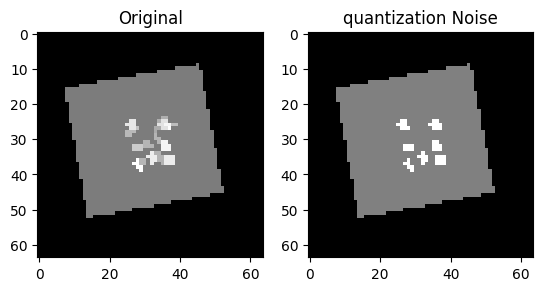

In [50]:

img = np.load(f'./ground_truth/64/0.npy').squeeze()
img_torch = phantom_to_torch(img)

# add {type} noise to the image
noise_type = 'quantization'
noise_img = add_selected_noise(img_torch, noise_type=noise_type, levels=2.0)

# plot the images side by side
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(noise_img.squeeze(), cmap='gray')
plt.title(f'{noise_type} Noise')

# calculate the psnr
# these need to be numpy arrays
psnr = compare_psnr(img_torch.numpy(), noise_img.numpy())
print(f'PSNR: {psnr}')

# now create noise level and resolution subfolders in the sample folder

In [101]:
# first resolution subfolders 64, 128, 256, 512
# next noise level subfolders 0.05, 0.09, .15, .20

# these are subfolders of the noise type folders, which are subfolders of the current directory
# so the path is ./noise_type/resolution/noise_level/phantom_phantomid_noisetype_noiselevel.npy
for key in NOISE_FUNCTIONS.keys():
    for res in [6, 7, 8, 9]:
        for noise_level in [0.05, 0.09, 0.15, 0.20]:
            # only create the folder if it doesn't exist
            os.makedirs(f'./{key}/resolution_{2**res}/noise_level_{noise_level}', exist_ok=True)

# now apply these noise levels to the ground truth

PSNR: 27.79478044891645 -- Target PSNR: 27.6 -- PSNR Error: 0.195


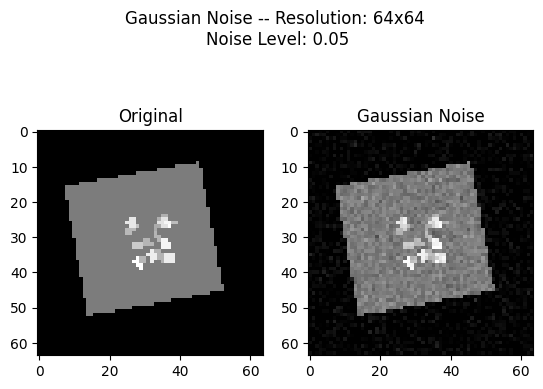

PSNR: 22.688243287619137 -- Target PSNR: 22 -- PSNR Error: 0.688


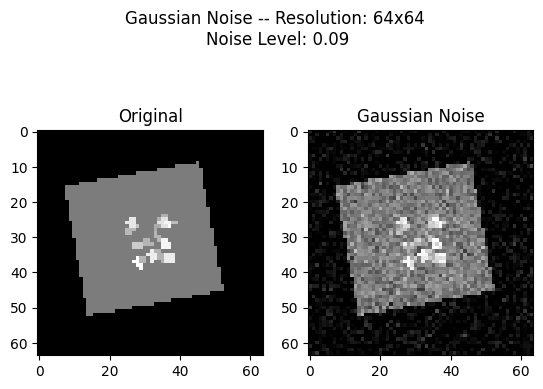

PSNR: 18.20137674714626 -- Target PSNR: 18.2 -- PSNR Error: 0.001


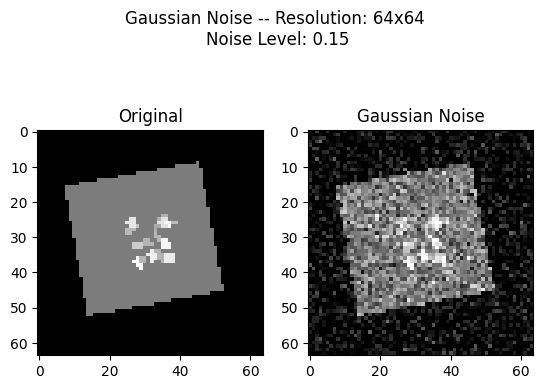

PSNR: 15.896428518060507 -- Target PSNR: 15.7 -- PSNR Error: 0.196


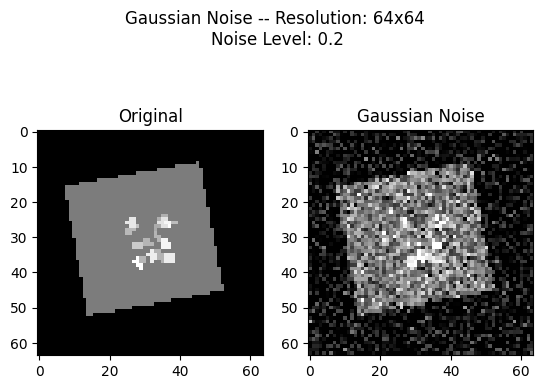

PSNR: 27.89215566422062 -- Target PSNR: 27.6 -- PSNR Error: 0.292


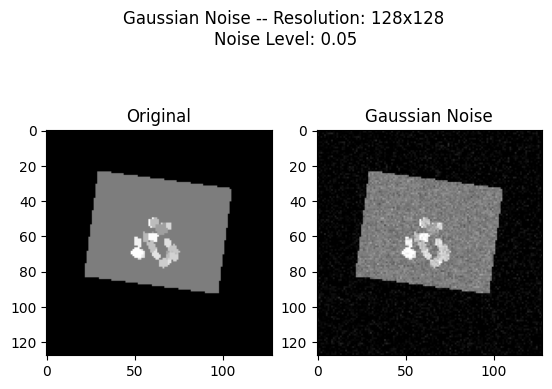

PSNR: 22.825945354199337 -- Target PSNR: 22 -- PSNR Error: 0.826


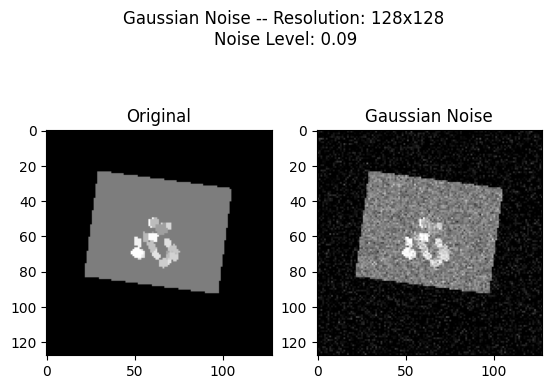

PSNR: 18.45218999841408 -- Target PSNR: 18.2 -- PSNR Error: 0.252


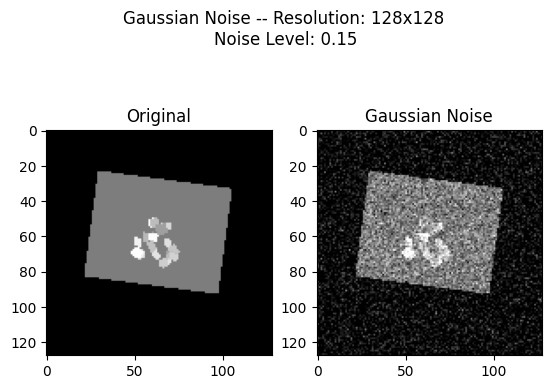

PSNR: 15.978447471456468 -- Target PSNR: 15.7 -- PSNR Error: 0.278


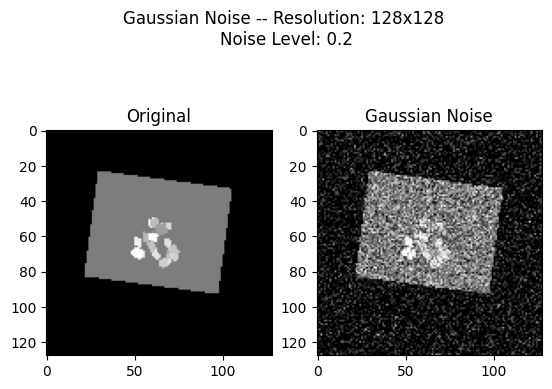

PSNR: 27.64111163920234 -- Target PSNR: 27.6 -- PSNR Error: 0.041


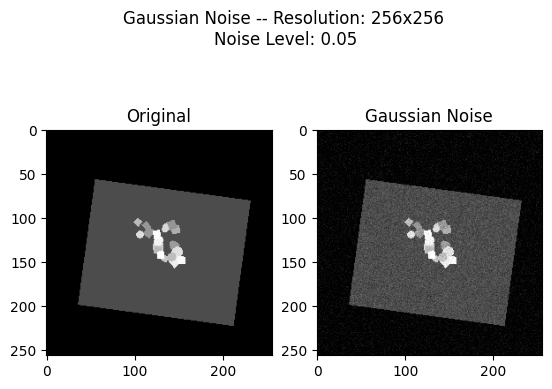

PSNR: 22.545746373378883 -- Target PSNR: 22 -- PSNR Error: 0.546


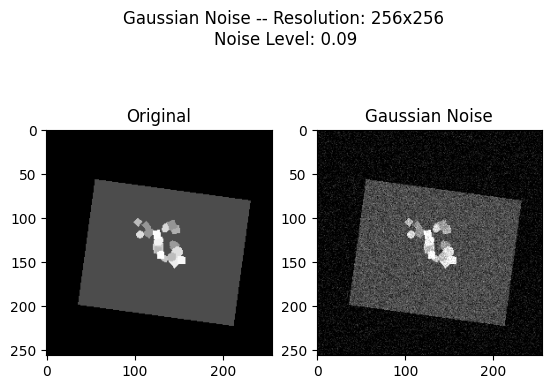

PSNR: 18.214845848374758 -- Target PSNR: 18.2 -- PSNR Error: 0.015


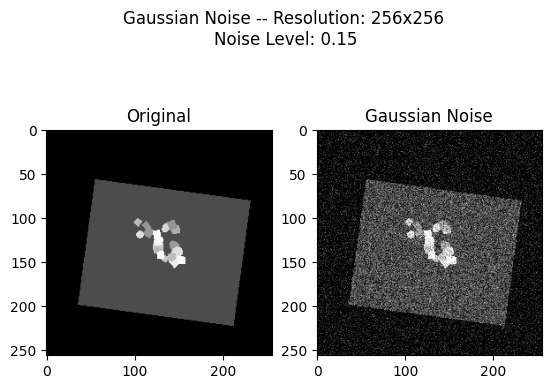

PSNR: 15.791820515642133 -- Target PSNR: 15.7 -- PSNR Error: 0.092


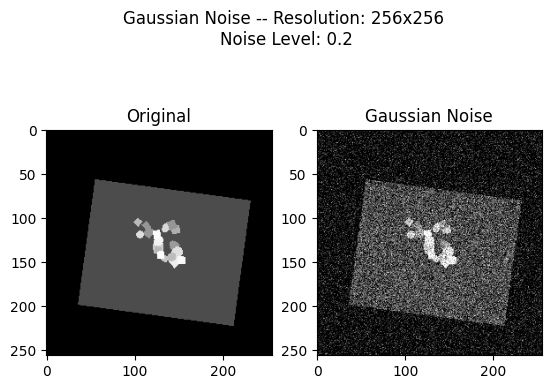

PSNR: 27.91463625129127 -- Target PSNR: 27.6 -- PSNR Error: 0.315


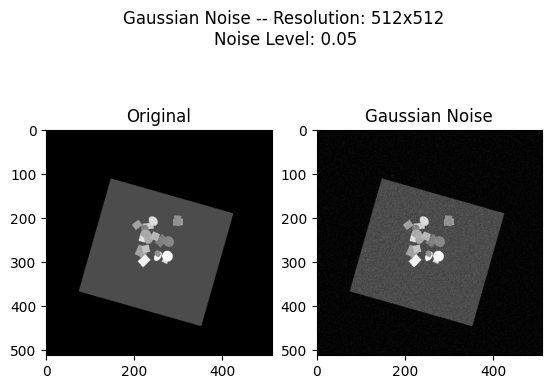

PSNR: 22.811781990858258 -- Target PSNR: 22 -- PSNR Error: 0.812


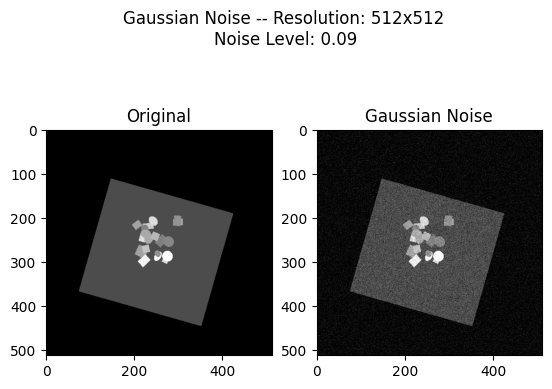

PSNR: 18.448923052022252 -- Target PSNR: 18.2 -- PSNR Error: 0.249


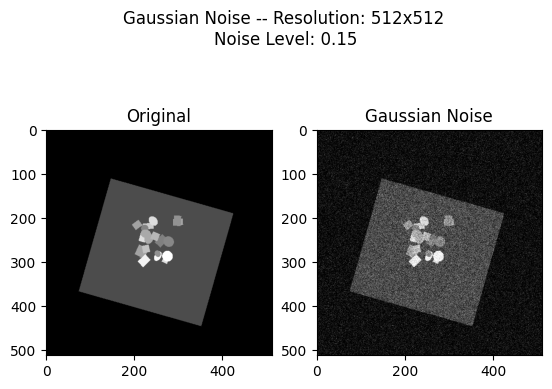

PSNR: 16.100633643650333 -- Target PSNR: 15.7 -- PSNR Error: 0.401


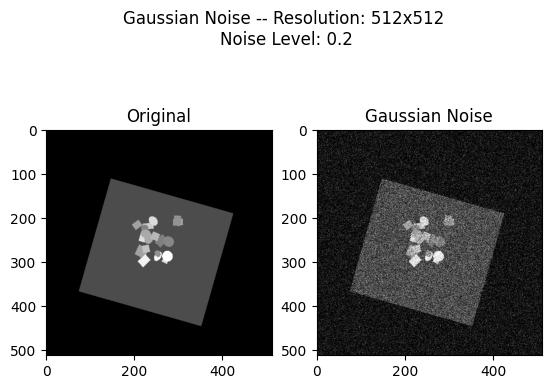

TypeError: add_salt_and_pepper_noise() got an unexpected keyword argument 'noise_factor'

In [141]:
# apply to the first 64 res phantom and plot for sanity check first
# calculate the psnr
# these need to be numpy arrays

for key in NOISE_FUNCTIONS.keys():
    for res in [6, 7, 8, 9]:
        for noise_level in [0.05, 0.09, 0.15, 0.20]:
            # load the phantom
            img = np.load(f'./ground_truth/{2**res}/0.npy').squeeze()
            img_torch = phantom_to_torch(img)
            
            # Set parameters depending on the noise type
            noise_kwargs = {}
            if param_name:  # Skip noise functions that do not have a parameter to optimize
                noise_kwargs[param_name] = noise_level
            
            # Add noise to the image
            noise_img = add_selected_noise(img_torch, noise_type=key, **noise_kwargs)
            
            # Calculate the psnr
            psnr = compare_psnr(img_torch.numpy(), noise_img.numpy())
            
            if noise_level == 0.05:
                target_psnr = 27.6
            elif noise_level == 0.09:
                target_psnr = 22
            elif noise_level == 0.15:
                target_psnr = 18.2
            elif noise_level == 0.20:
                target_psnr = 15.7
            print(f'PSNR: {psnr} -- Target PSNR: {target_psnr} -- PSNR Error: {round(abs(psnr-target_psnr), 3)}')
            # plot the images side by side
            plt.figure()
            # title plot with noise type, resolution, and noise level
            plt.suptitle(f'{key.capitalize()} Noise -- Resolution: {2**res}x{2**res} \nNoise Level: {noise_level}')
            plt.subplot(1, 2, 1)
            plt.imshow(img, cmap='gray')
            plt.title('Original')
            plt.subplot(1, 2, 2)
            plt.imshow(noise_img.squeeze(), cmap='gray')
            plt.title(f'{key.capitalize()} Noise')
            plt.show()
            plt.close()